![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Introduction to Machine Learning </center>
## <center> Lecture 20 - CNN Architectures</center>
### <center> Transfer Learning</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/IntroductionToMachineLearning/20_CNN_Architectures/MainTransferLearning.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
#-- Imports:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

#-- torch:
import torch

For Colab users:

In [4]:
!wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/IntroductionToMachineLearning/20_CNN_Architectures/TransferLearningExampleAux.py

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
#-- Record figures during training:
from TransferLearningExampleAux import Plot, Recorder, TrainLoop, ValidationLoop, TrainModel, LearningRateSweep, OneCycleScheduler

### Load dataset:
https://www.kaggle.com/puneet6060/intel-image-classification

In [6]:
import torchvision
import torchvision.transforms as transforms

vMean = np.array([0.48501961, 0.45795686, 0.40760392])
vStd  = np.array([0.22899216, 0.224     , 0.225     ])

oTransforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=vMean, std=vStd),
])

trainPath = '../../data/111880_269359_bundle_archive/seg_train/seg_train'
testPath  = '../../data/111880_269359_bundle_archive/seg_test/seg_test'

oTrainSet = torchvision.datasets.ImageFolder(root=trainPath, transform=oTransforms)
oTestSet  = torchvision.datasets.ImageFolder(root=testPath,  transform=oTransforms)
oTrainSet.classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

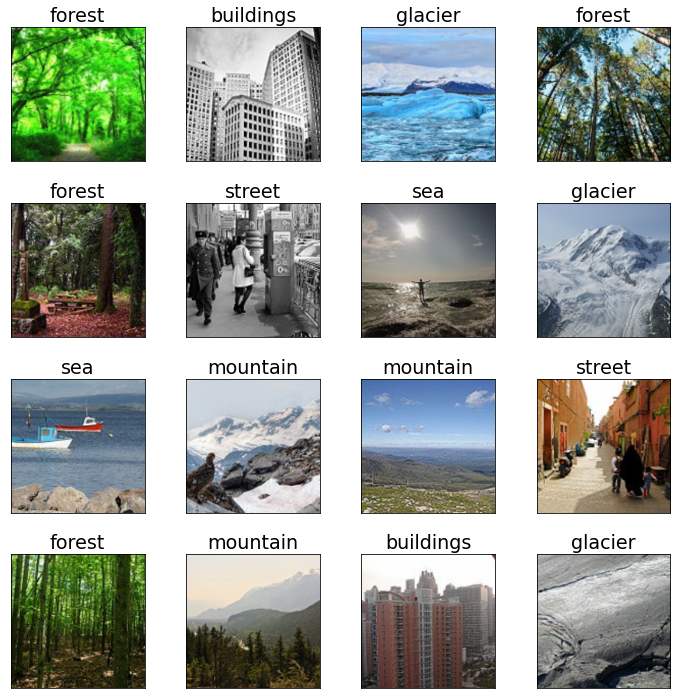

In [7]:
oTrainDL = torch.utils.data.DataLoader(oTrainSet, batch_size=16, shuffle=True)
mImages, vLabels = next(iter(oTrainDL))
mImages = mImages
vLabels = vLabels
fig, _  = plt.subplots(4, 4, figsize=(10,10))
for ii, ax in enumerate(fig.axes):
    ax.imshow(np.clip(mImages[ii].numpy().transpose((1,2,0)) * vStd[None,None,:] + vMean[None,None,:], 0, 1))
    ax.set_title(oTrainSet.classes[vLabels[ii]])
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
plt.show()

### Train a new ResNet (no transfer learning)

In [8]:
import torch.nn as nn
import torchsummary

def GetModel():
    return torchvision.models.resnet50(pretrained=False)

torchsummary.summary(GetModel(), (3, 224, 224)); print()

------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        128
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          128
|    |    └─ReLU: 3-6                    [-1, 64, 5

In [9]:
#-- Data loaders:
batchSize = 32
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   num_workers=2)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2)

In [10]:
#-- Device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda', index=0)

In [11]:
import torch.optim as optim

#-- Loss function:
LossFunc = nn.CrossEntropyLoss()

<IPython.core.display.Javascript object>


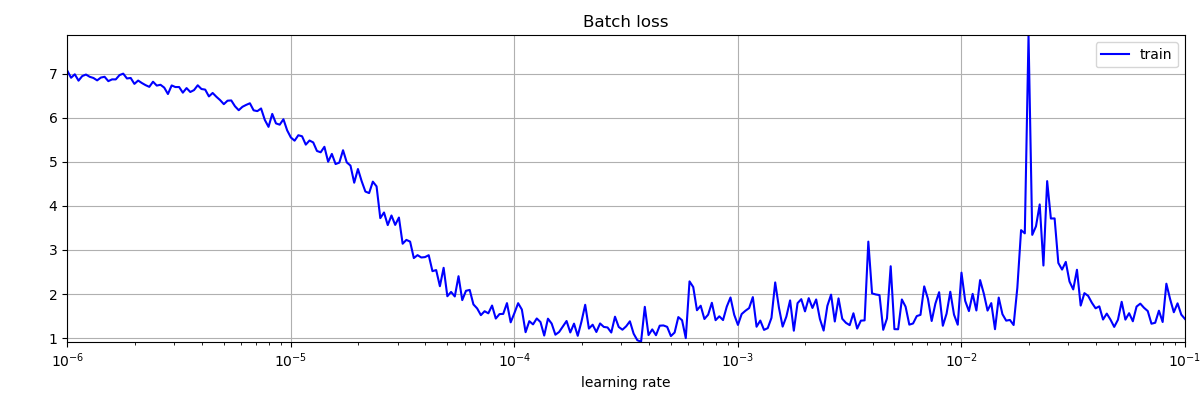

In [12]:
%matplotlib notebook
#-- Colab users should use `inline`
# %matplotlib inline

#-- Sweep learning rate:
oModel        = GetModel().to(device)
oOptim        = optim.AdamW(oModel.parameters(), lr=0.1, betas=(0.9, 0.99), weight_decay=1e-4)
vLearningRate = np.logspace(-6, -1, 301)
oRecorder     = LearningRateSweep(oModel, oTrainDL, LossFunc, oOptim, vLearningRate)

In [ ]:
%matplotlib inline
oRecorder.fig

<IPython.core.display.Javascript object>


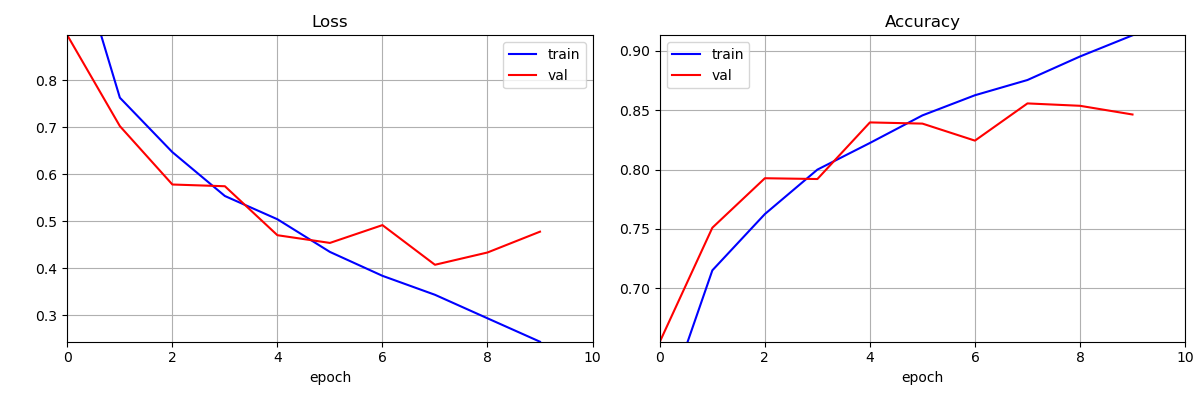

Epoch   0: | Train loss: 1.13422 | Val loss: 0.89517 | Train Accuracy: 0.5874 | Val Accuracy: 0.6550 | epoch time: 224.748 | <-- Checkpoint!
Epoch   1: | Train loss: 0.76253 | Val loss: 0.70208 | Train Accuracy: 0.7151 | Val Accuracy: 0.7510 | epoch time: 225.091 | <-- Checkpoint!
Epoch   2: | Train loss: 0.64674 | Val loss: 0.57791 | Train Accuracy: 0.7625 | Val Accuracy: 0.7927 | epoch time: 222.859 | <-- Checkpoint!
Epoch   3: | Train loss: 0.55346 | Val loss: 0.57424 | Train Accuracy: 0.7999 | Val Accuracy: 0.7920 | epoch time: 223.039 |
Epoch   4: | Train loss: 0.50403 | Val loss: 0.47008 | Train Accuracy: 0.8224 | Val Accuracy: 0.8397 | epoch time: 227.106 | <-- Checkpoint!
Epoch   5: | Train loss: 0.43454 | Val loss: 0.45369 | Train Accuracy: 0.8456 | Val Accuracy: 0.8387 | epoch time: 225.780 |
Epoch   6: | Train loss: 0.38374 | Val loss: 0.49157 | Train Accuracy: 0.8625 | Val Accuracy: 0.8243 | epoch time: 225.096 |
Epoch   7: | Train loss: 0.34340 | Val loss: 0.40721 | Train 

(array([0.89517006, 0.70208488, 0.57791444, 0.57423518, 0.47008292,
        0.45369316, 0.49156989, 0.40720683, 0.43332929, 0.47761369]),
 array([0.655     , 0.751     , 0.79266667, 0.792     , 0.83966667,
        0.83866667, 0.82433333, 0.85566667, 0.85366667, 0.84633333]))

In [13]:
%matplotlib notebook

oModel = GetModel().to(device)
oOptim = optim.AdamW(oModel.parameters(), lr=1e-4, betas=(0.9, 0.99), weight_decay=2e-4)
TrainModel(oModel, oTrainDL, oTestDL, LossFunc, 10, oOptim)

### Use a pretrained ResNet (transfer learning):

In [14]:
import torch.nn as nn
import torchsummary

def GetPretrainedModel():
    oModel = torchvision.models.resnet50(pretrained=True)
    #-- freeze weights:
    for mParam in oModel.parameters():
        mParam.requires_grad = False
        
    #-- Replace classifier head:
    dIn = oModel.fc.in_features
    oModel.fc = nn.Sequential(
        nn.Linear(dIn, 100), nn.ReLU(),
        nn.Linear(100, 6)
    )
    
    return oModel

torchsummary.summary(GetPretrainedModel(), (3, 224, 224)); print()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\Or/.cache\torch\hub\checkpoints\resnet50-19c8e357.pth



------------------------------------------------------------------------------------------
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                 

<IPython.core.display.Javascript object>


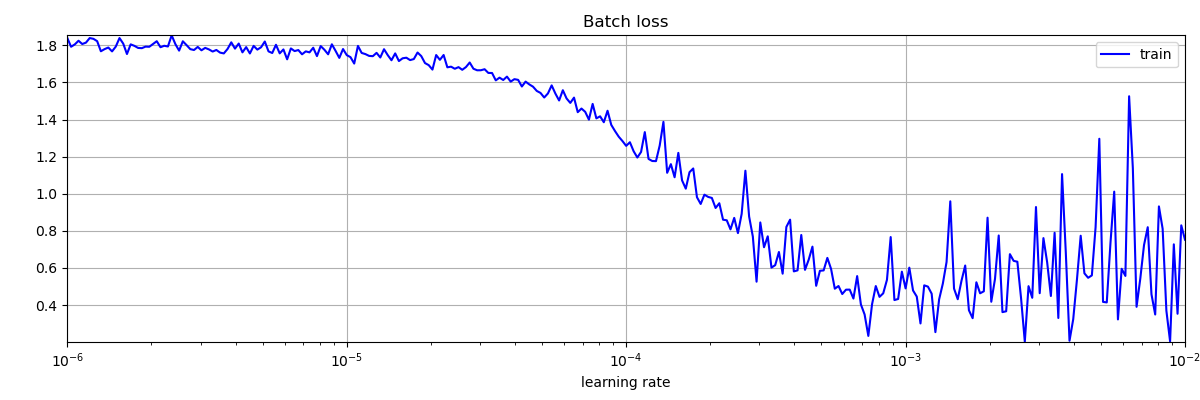

In [15]:
%matplotlib notebook
#-- Colab users should use `inline`
# %matplotlib inline

#-- Sweep learning rate:
oModel        = GetPretrainedModel().to(device)
oOptim        = optim.AdamW(oModel.parameters(), lr=0.1, betas=(0.9, 0.99), weight_decay=1e-4)
vLearningRate = np.logspace(-6, -2, 301)
oRecorder     = LearningRateSweep(oModel, oTrainDL, LossFunc, oOptim, vLearningRate)

In [ ]:
%matplotlib inline
oRecorder.fig

<IPython.core.display.Javascript object>


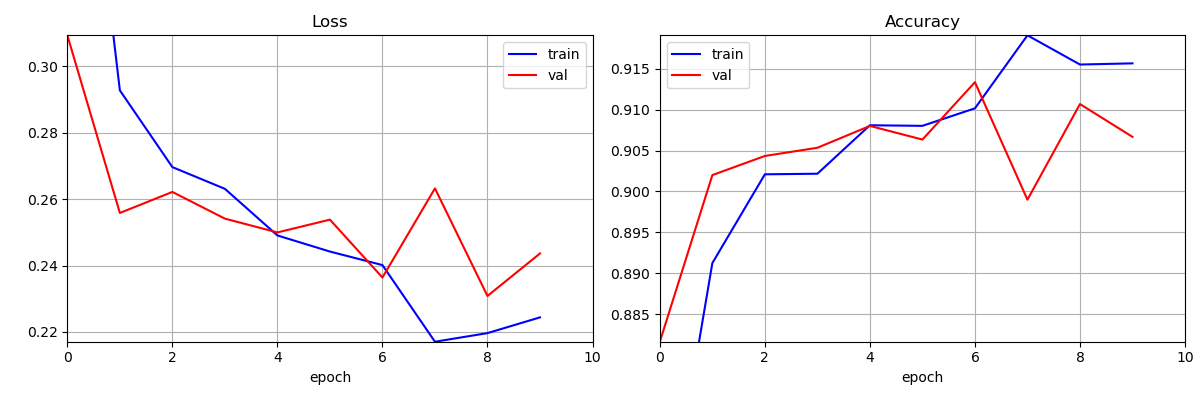

Epoch   0: | Train loss: 0.42684 | Val loss: 0.30938 | Train Accuracy: 0.8534 | Val Accuracy: 0.8817 | epoch time: 88.368 | <-- Checkpoint!
Epoch   1: | Train loss: 0.29279 | Val loss: 0.25585 | Train Accuracy: 0.8913 | Val Accuracy: 0.9020 | epoch time: 89.486 | <-- Checkpoint!
Epoch   2: | Train loss: 0.26966 | Val loss: 0.26218 | Train Accuracy: 0.9021 | Val Accuracy: 0.9043 | epoch time: 88.058 | <-- Checkpoint!
Epoch   3: | Train loss: 0.26312 | Val loss: 0.25413 | Train Accuracy: 0.9022 | Val Accuracy: 0.9053 | epoch time: 89.636 | <-- Checkpoint!
Epoch   4: | Train loss: 0.24907 | Val loss: 0.24998 | Train Accuracy: 0.9081 | Val Accuracy: 0.9080 | epoch time: 89.663 | <-- Checkpoint!
Epoch   5: | Train loss: 0.24421 | Val loss: 0.25383 | Train Accuracy: 0.9080 | Val Accuracy: 0.9063 | epoch time: 89.715 |
Epoch   6: | Train loss: 0.24013 | Val loss: 0.23639 | Train Accuracy: 0.9101 | Val Accuracy: 0.9133 | epoch time: 89.678 | <-- Checkpoint!
Epoch   7: | Train loss: 0.21704 | V

In [16]:
%matplotlib notebook

oModel = GetPretrainedModel().to(device)
oOptim = optim.AdamW(oModel.parameters(), lr=5e-4, betas=(0.9, 0.99), weight_decay=2e-4)
TrainModel(oModel, oTrainDL, oTestDL, LossFunc, 10, oOptim)